# Analysis of chemo diversity on pharmacological and biological activities

The [dataset](results/activities_2022-01-29_16-33-05.csv) is obtained from the Scopus downloader version 2.0 from the [base set](data/activities.csv) of chemical compounds and activities.

**TODO** check:

- <https://stackoverflow.com/questions/53927460/select-rows-in-pandas-multiindex-dataframe>
- <https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#multiindex-query-syntax>


## Loading data obtained from Scopus

### Boilerplate

Some Python configuration.


In [16]:
from pathlib import Path
from itertools import islice, product
from pprint import pprint

import pandas as pd
import numpy as np
import numpy.typing as npt
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
import scopus.biblio_extractor as bex
import catk

np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.float_format", lambda x: "{:.3f}".format(x))
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 20)
pd.set_option("display.min_rows", 10)

# (11.7, 8.27) = A4 landscape
# sns.set_theme(style="dark", palette="muted", font_scale=1.10, rc={"figure.figsize": (16.54, 11.7)})
sns.set_theme(style="dark", palette="muted", font_scale=1.10, rc={"figure.figsize": (23.4, 16.54)})


DATASET_FILENAME = Path("results/pharmaco_chemistry_2_cross_2022-10-06_18-16-36.csv")
# DATASET_FILENAME = Path("results/pharmaco_chemistry_cross_2022-05-19_17-18-20.csv")
# DATASET_FILENAME = Path("results/activities_2022-01-29_16-33-05.csv")
print(f"{DATASET_FILENAME.stem = } {DATASET_FILENAME.suffix = }")

SEED = 42


DATASET_FILENAME.stem = 'pharmaco_chemistry_2_cross_2022-10-06_18-16-36' DATASET_FILENAME.suffix = '.csv'


### Loading the CSV file

Now, we load the dataset we'll use in this Notebook. It is generated using [our tool](biblio_extractor.py) in the same repository.
The dataset is a 106 \* 66 matrix, with rows and columns indexed by three levels (using Pandas's `MultiIndex`) as follows:

- level 0 is _class_ (chemical, biological or pharmacological class)
- level 1 is _name_ (compound or activity, a.k.a. keyword)
- level 2 is _kind_ (either _w/o_ for _without_ or _w/_ for _with_)

The matrix is indexed by _two_ disjoint finite sets of keywords:

- **rows**: a set of 53 (chemical) coumpounds = {acridine, triterpene, ...}
- **columns**: a set of 33 (biological, pharmacological) activities = {germination, cytotoxicity, ...}

An example is shown below, restricted to two compounds and two activities.
Note that this is **not** an extract of the whole dataset, the (w/o, w/o) cells being smaller here.

|                   |            |     | germination | germination | cytotoxicity | cytotoxicity |
| ----------------- | ---------- | --- | ----------- | ----------- | ------------ | ------------ |
|                   |            |     | allelopathy | allelopathy | pharmaco     | pharmaco     |
|                   |            |     | w/o         | w/          | w/o          | w/           |
| alkaloid          | acridine   | w/o | 2100        | 32          | 28           | 2104         |
| alkaloid          | acridine   | w/  | 1294        | 11          | 9            | 1296         |
| terpenoid/terpene | triterpene | w/o | 1283        | 11          | 9            | 1285         |
| terpenoid/terpene | triterpene | w/  | 2111        | 32          | 28           | 2115         |

Let $M$ be this matrix, and for each couple of keywords made of a compound and and activity, call $M_{ij} = (c_i, a_j)$, the **ij confusion submatrix**.
Assume that $M_{ij}$ is of the form :
\begin{bmatrix}
FF & FT\\
TF & TT
\end{bmatrix}

Where :

- $FF = (\text{w/o}, \text{w/o})$ is the number of papers that have **neither** the $c_i$ compound **nor** the $a_j$ activity;
- $FT = (\text{w/o}, \text{w/})$ is the number of papers that have the $a_j$ activity but **not** the $c_i$ compound;
- $TF = (\text{w/}, \text{w/o})$ is the number of papers that have the $c_i$ compound but **not** the $a_j$ activity;
- $TT = (\text{w/}, \text{w/})$ is the number of papers that have **both** the $c_i$ compound **and** the $a_j$ activity.

We avoid the open world hypothesis by restricting the analysis to the paper in the domain $D$,
which is the set of papers that have at least one compound and one activity.
By construction:

- $FF + FT$ and $TF + TT$ are constants for each $c_i$ (whatever the choice of $a_j$) and is the total number of papers in $D$ with the $c_i$ comppound;
- $FF + TF$ and $FT + TT$ are constants for each $a_j$ (whatever the choice of $c_i$) and is the total number of papers in $D$ with the $a_j$ activity.
- thus each confusion matrix $M_{ij}$ is such that $FF + FT + TF + TT = |D|$ where $|D|$ is _the total number of paper_ under scrutiny.


In [2]:
dataset, margin_rows, margin_cols, number_of_papers = bex.load_results(DATASET_FILENAME)
all_compounds = set(dataset.index.get_level_values(1))
all_activities = set(dataset.columns.get_level_values(1))

print(f"The domain contains {number_of_papers} papers")
display(dataset)


The domain contains 438174 papers


abiotic 
 ... 
 pharmaco 
 toxicity 
 
 
 
 
 
 heat stress/heat tolerance/heat resistance/heat impact/heat change/temperature stress/temperature tolerance/temperature resistance/temperature impact/temperature change 
 heavy metal stress/metallic trace element stress/heavy metal tolerance/metallic trace element tolerance/heavy metal resistance/metallic trace element resistance/heavy metal impact/metallic trace element impact/heavy metal change/metallic trace element change 
 hydric stress/drought stress/hydric tolerance/drought tolerance/hydric resistance/drought resistance/hydric impact/drought impact/hydric change/drought change 
 ... 
 sedative/analgesic 
 wound 
 toxicity 
 
 
 
 
 
 w/o 
 w/ 
 w/o 
 w/ 
 w/o 
 ... 
 w/ 
 w/o 
 w/ 
 w/o 
 w/ 
 
 
 
 
 alkaloid 
 benzylamine 
 w/o 
 433779 
 3118 
 436385 
 512 
 434379 
 ... 
 15615 
 425152 
 11745 
 379812 
 57085 
 
 
 w/ 
 1272 
 5 
 1277 
 0 
 1277 
 ... 
 126 
 1252 
 25 
 1058 
 219 
 
 
 colchicine 
 w/o 
 425726 
 3093 
 428307 
 512 
 426320 
 ... 
 15337 
 417371 
 11448 
 373134 
 55685 
 
 
 w/ 
 9325 
 30 
 9355 
 0 
 9336 
 ... 
 404 
 9033 
 322 
 7736 
 1619 
 
 
 cyclopeptide 
 w/o 
 431558 
 3118 
 434166 
 510 
 432160 
 ... 
 15641 
 422972 
 11704 
 377809 
 56867 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 terpenoid/terpene 
 sesterterpene 
 w/ 
 283 
 0 
 283 
 0 
 283 
 ... 
 4 
 281 
 2 
 264 
 19 
 
 
 tetraterpene/carotenoid/xanthophyll 
 w/o 
 398646 
 2592 
 400844 
 394 
 399600 
 ... 
 15637 
 389657 
 11581 
 346026 
 55212 
 
 
 w/ 
 36405 
 531 
 36818 
 118 
 36056 
 ... 
 104 
 36747 
 189 
 34844 
 2092 
 
 
 triterpene/saponin 
 w/o 
 410959 
 3049 
 413499 
 509 
 411529 
 ... 
 14638 
 403258 
 10750 
 360424 
 53584 
 
 
 w/ 
 24092 
 74 
 24163 
 3 
 24127 
 ... 
 1103 
 23146 
 1020 
 20446 
 3720 
 
 
 
 108 rows × 74 columns

### Extractiong the  "w/, w/o" matrix

We can extract the 53\*33 matrix we use in the version version of this software, where we had only the with/with queries.
In our small running example, that would be:

|                   |            | germination | cytotoxicity |
| ----------------- | ---------- | ----------- | ------------ |
|                   |            | allelopathy | pharmaco     |
| alkaloid          | acridine   | 11          | 1296         |
| terpenoid/terpene | triterpene | 32          | 2115         |


In [3]:
with_with_matrix = dataset.xs("w/", level=2).xs("w/", level=2, axis=1)
display(with_with_matrix)


abiotic 
 ... 
 pharmaco 
 toxicity 
 
 
 
 
 heat stress/heat tolerance/heat resistance/heat impact/heat change/temperature stress/temperature tolerance/temperature resistance/temperature impact/temperature change 
 heavy metal stress/metallic trace element stress/heavy metal tolerance/metallic trace element tolerance/heavy metal resistance/metallic trace element resistance/heavy metal impact/metallic trace element impact/heavy metal change/metallic trace element change 
 hydric stress/drought stress/hydric tolerance/drought tolerance/hydric resistance/drought resistance/hydric impact/drought impact/hydric change/drought change 
 ph stress/ph tolerance/ph resistance/ph impact/ph change 
 salt stress/salinity stress/salt tolerance/salinity tolerance/salt resistance/salinity resistance/salt impact/salinity impact/salt change/salinity change 
 ... 
 obesity 
 rheumatism 
 sedative/analgesic 
 wound 
 toxicity 
 
 
 
 
 alkaloid 
 benzylamine 
 5 
 0 
 0 
 4 
 6 
 ... 
 57 
 0 
 126 
 25 
 219 
 
 
 colchicine 
 30 
 0 
 19 
 3 
 14 
 ... 
 235 
 108 
 404 
 322 
 1619 
 
 
 cyclopeptide 
 5 
 2 
 2 
 2 
 6 
 ... 
 60 
 32 
 100 
 66 
 437 
 
 
 imidazole 
 149 
 3 
 8 
 75 
 34 
 ... 
 386 
 6 
 1416 
 657 
 3858 
 
 
 indole 
 193 
 81 
 342 
 70 
 562 
 ... 
 489 
 31 
 1278 
 638 
 4140 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 terpenoid/terpene 
 polyterpene 
 0 
 0 
 0 
 0 
 0 
 ... 
 0 
 0 
 0 
 0 
 2 
 
 
 sesquiterpene 
 28 
 0 
 33 
 0 
 21 
 ... 
 85 
 45 
 265 
 254 
 1033 
 
 
 sesterterpene 
 0 
 0 
 0 
 0 
 0 
 ... 
 2 
 1 
 4 
 2 
 19 
 
 
 tetraterpene/carotenoid/xanthophyll 
 531 
 118 
 880 
 44 
 1159 
 ... 
 651 
 11 
 104 
 189 
 2092 
 
 
 triterpene/saponin 
 74 
 3 
 39 
 8 
 37 
 ... 
 562 
 176 
 1103 
 1020 
 3720 
 
 
 
 54 rows × 37 columns

## Analyzing data

### Extracting the (confusion) submatrices

Lets illustrate the content of this table. The **2 by 2 submatrix** about _colchicine_ and _cytotoxicity_ is as follows.


In [4]:
example_submatrix = dataset.loc[
    ("alkaloid", "colchicine"),
    ("pharmaco", "cytotoxicity"),
]
print(f"Among {number_of_papers} papers, there are")
for i, j in product(bex.SELECTORS, bex.SELECTORS):
    print(f"- {example_submatrix.loc[i,j]} papers {i} acridine and {j} cytotoxicity in their keywords")

print("The colchicine and cytotoxicity confusion matrix is as follows")
display(example_submatrix)


Among 438174 papers, there are
- 371477 papers w/o acridine and w/o cytotoxicity in their keywords
- 57342 papers w/o acridine and w/ cytotoxicity in their keywords
- 7697 papers w/ acridine and w/o cytotoxicity in their keywords
- 1658 papers w/ acridine and w/ cytotoxicity in their keywords
The colchicine and cytotoxicity confusion matrix is as follows


,w/o,w/
w/o,371477,57342
w/,7697,1658


### Metrics

We given different metrics to be applied on 2x2 submatrices, see the usual one for _confusion matrix_ in <https://en.wikipedia.org/wiki/Confusion_matrix#Table_of_confusion>

In [26]:
# def intersection_metric(arr):
#     """The trivial one. Just keep the bottom right cell. Amount to compute on "the old matrix" """
#     [FF, FT], [TF, TT] = arr.reshape(2, 2)
#     return TT / (FF + FT + TF + TT)


def tt_projection_metric(arr):
    """The trivial one. Just keep the bottom right cell. Amount to compute on "the old matrix" """
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT


def row_implication_metric(arr):
    """The % of paper that have both keywords among the first one. Values add to 1 row wise"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / (TF + TT)


def col_implication_metric(arr):
    """The % of paper that have both keywords among the second one. Values add to 1 col wise"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / (FT + TT)


def fowlkes_mallows_metric(arr):
    """Computes the Fowlkes-Mallows index: sqrt(the product of row and col implication)"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / np.sqrt((FT + TT) * (TF + TT))


def accuracy_metric(arr):
    """Computes the accuracy"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return (TT + FF) / (FF + FT + TF + TT)


def x_metric(arr):
    """Some another one by our own"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return (FF + TT - FT - TF) / (FF + FT + TF + TT)


def fraction_metric(arr):
    """The % of paper that have both keywords among the ones having at least one."""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / (FT + TF - TT)


def odds_metric(arr):
    """The odds of having related keywords."""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return (FF * TT + 0.5) / (FT * TF + 0.5)


def logodds_metric(arr):
    """The log odds of having related keywords."""
    return np.log(odds_metric(arr))


metrics = [
    tt_projection_metric,
    row_implication_metric,
    col_implication_metric,
    fowlkes_mallows_metric,
    fraction_metric,
    odds_metric,
    accuracy_metric,
    # logodds_metric,
]


print("An example on the colchicine/cytotoxicity submatrix, its score for each metric")
print(example_submatrix)

for metric in metrics:
    print(f"- {metric.__name__:<22} = {metric(example_submatrix.values)}")


An example on the colchicine/cytotoxicity submatrix, its score for each metric
        w/o     w/
w/o  371477  57342
w/     7697   1658
- tt_projection_metric   = 1658
- row_implication_metric = 0.17723142704436132
- col_implication_metric = 0.028101694915254237
- fowlkes_mallows_metric = 0.07057268233669299
- fraction_metric        = 0.026159259083952602
- odds_metric            = 1.3954752320538644
- accuracy_metric        = 0.8515680985179404


### Applying the metrics

First, we filter out rows and cols with too few papers, we ask for at leat 0.1% of the total number of papers.
From now on, we'll stick to the **filtered dataset**.

In [27]:
ROW_THRESHOLD = number_of_papers // 1000
COL_THRESHOLD = number_of_papers // 1000
print(f"Thresholds for rows={ROW_THRESHOLD} and cols={COL_THRESHOLD}")

rows_filter = margin_rows.xs(bex.SELECTORS[1], level=2) >= ROW_THRESHOLD
cols_filter = margin_cols.xs(bex.SELECTORS[1], level=2) >= COL_THRESHOLD
filtered = dataset.loc[rows_filter, cols_filter]
filtered.index.name = "Compounds"
filtered.columns.name = "Activities"
display(filtered)

Thresholds for rows=438 and cols=438


abiotic 
 ... 
 pharmaco 
 toxicity 
 
 
 
 
 
 heat stress/heat tolerance/heat resistance/heat impact/heat change/temperature stress/temperature tolerance/temperature resistance/temperature impact/temperature change 
 heavy metal stress/metallic trace element stress/heavy metal tolerance/metallic trace element tolerance/heavy metal resistance/metallic trace element resistance/heavy metal impact/metallic trace element impact/heavy metal change/metallic trace element change 
 hydric stress/drought stress/hydric tolerance/drought tolerance/hydric resistance/drought resistance/hydric impact/drought impact/hydric change/drought change 
 ... 
 sedative/analgesic 
 wound 
 toxicity 
 
 
 
 
 
 w/o 
 w/ 
 w/o 
 w/ 
 w/o 
 ... 
 w/ 
 w/o 
 w/ 
 w/o 
 w/ 
 
 
 
 
 alkaloid 
 benzylamine 
 w/o 
 433779 
 3118 
 436385 
 512 
 434379 
 ... 
 15615 
 425152 
 11745 
 379812 
 57085 
 
 
 w/ 
 1272 
 5 
 1277 
 0 
 1277 
 ... 
 126 
 1252 
 25 
 1058 
 219 
 
 
 colchicine 
 w/o 
 425726 
 3093 
 428307 
 512 
 426320 
 ... 
 15337 
 417371 
 11448 
 373134 
 55685 
 
 
 w/ 
 9325 
 30 
 9355 
 0 
 9336 
 ... 
 404 
 9033 
 322 
 7736 
 1619 
 
 
 cyclopeptide 
 w/o 
 431558 
 3118 
 434166 
 510 
 432160 
 ... 
 15641 
 422972 
 11704 
 377809 
 56867 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 terpenoid/terpene 
 sesquiterpene 
 w/ 
 9277 
 28 
 9305 
 0 
 9272 
 ... 
 265 
 9051 
 254 
 8272 
 1033 
 
 
 tetraterpene/carotenoid/xanthophyll 
 w/o 
 398646 
 2592 
 400844 
 394 
 399600 
 ... 
 15637 
 389657 
 11581 
 346026 
 55212 
 
 
 w/ 
 36405 
 531 
 36818 
 118 
 36056 
 ... 
 104 
 36747 
 189 
 34844 
 2092 
 
 
 triterpene/saponin 
 w/o 
 410959 
 3049 
 413499 
 509 
 411529 
 ... 
 14638 
 403258 
 10750 
 360424 
 53584 
 
 
 w/ 
 24092 
 74 
 24163 
 3 
 24127 
 ... 
 1103 
 23146 
 1020 
 20446 
 3720 
 
 
 
 88 rows × 70 columns

For instance, let's apply the _row_implication_metric_ to the filtered dataset.

In [28]:
def apply_metric(data, func, write=False):
    C, A = len(data.index) // 2, len(data.columns) // 2
    values = np.moveaxis(data.values.reshape((C, 2, A, 2)), 1, -2).reshape((C * A, 4))
    matrix = np.apply_along_axis(func, 1, values).reshape((C, A))
    sub = data.xs(bex.SELECTORS[True], axis=0, level=2).xs(bex.SELECTORS[True], axis=1, level=2)
    df = pd.DataFrame(matrix, index=sub.index, columns=sub.columns)
    df.index.name = "Compounds"
    df.columns.name = "Activities"

    if write:
        filename = Path(f"{DATASET_FILENAME.stem}_{func.__namme__}{DATASET_FILENAME.suffix}")
        df.to_csv(Path("results") / filename)
    return df


apply_metric(filtered, odds_metric)


abiotic 
 ... 
 pharmaco 
 toxicity 
 
 
 
 
 heat stress/heat tolerance/heat resistance/heat impact/heat change/temperature stress/temperature tolerance/temperature resistance/temperature impact/temperature change 
 heavy metal stress/metallic trace element stress/heavy metal tolerance/metallic trace element tolerance/heavy metal resistance/metallic trace element resistance/heavy metal impact/metallic trace element impact/heavy metal change/metallic trace element change 
 hydric stress/drought stress/hydric tolerance/drought tolerance/hydric resistance/drought resistance/hydric impact/drought impact/hydric change/drought change 
 ph stress/ph tolerance/ph resistance/ph impact/ph change 
 salt stress/salinity stress/salt tolerance/salinity tolerance/salt resistance/salinity resistance/salt impact/salinity impact/salt change/salinity change 
 ... 
 obesity 
 rheumatism 
 sedative/analgesic 
 wound 
 toxicity 
 
 
 
 
 alkaloid 
 benzylamine 
 0.547 
 0.000 
 0.000 
 1.721 
 0.573 
 ... 
 1.843 
 0.000 
 2.953 
 0.723 
 1.377 
 
 
 colchicine 
 0.443 
 0.000 
 0.347 
 0.172 
 0.179 
 ... 
 1.014 
 7.003 
 1.217 
 1.300 
 1.402 
 
 
 cyclopeptide 
 0.198 
 0.487 
 0.098 
 0.311 
 0.207 
 ... 
 0.685 
 5.071 
 0.788 
 0.695 
 0.948 
 
 
 imidazole 
 0.930 
 0.109 
 0.059 
 1.924 
 0.177 
 ... 
 0.679 
 0.136 
 1.892 
 1.101 
 1.411 
 
 
 indole 
 1.011 
 2.891 
 2.432 
 1.474 
 2.901 
 ... 
 0.719 
 0.601 
 1.375 
 0.877 
 1.231 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 terpenoid/terpene 
 diterpene 
 0.350 
 0.000 
 0.377 
 0.091 
 0.367 
 ... 
 0.508 
 2.580 
 0.932 
 0.986 
 0.969 
 
 
 monoterpene 
 1.961 
 0.267 
 3.313 
 0.170 
 0.457 
 ... 
 0.247 
 3.239 
 1.430 
 0.967 
 1.143 
 
 
 sesquiterpene 
 0.415 
 0.000 
 0.611 
 0.000 
 0.270 
 ... 
 0.358 
 2.677 
 0.783 
 1.017 
 0.827 
 
 
 tetraterpene/carotenoid/xanthophyll 
 2.243 
 3.261 
 5.954 
 0.632 
 5.341 
 ... 
 0.687 
 0.147 
 0.070 
 0.173 
 0.376 
 
 
 triterpene/saponin 
 0.414 
 0.101 
 0.268 
 0.173 
 0.178 
 ... 
 0.933 
 4.694 
 1.305 
 1.653 
 1.224 
 
 
 
 44 rows × 35 columns

Now, compute all given metrics with a short summary.

In [29]:
score_df = {}
for metric in metrics:
    metric_name = metric.__name__
    score_df[metric_name] = apply_metric(filtered, metric, False)


scores_summary_df = pd.DataFrame.from_dict(
    {f_name: [df.values.min(), df.values.mean(), df.values.max(), df.values.std()] for f_name, df in score_df.items()},
    orient="index",
    columns=["min", "mean", "max", "std"],
)


scores_summary_df


,min,mean,max,std
tt_projection_metric,-1.000,487.734,55239.000,1957.334
row_implication_metric,-0.001,0.040,0.719,0.071
col_implication_metric,-0.001,0.028,0.784,0.057
fowlkes_mallows_metric,-0.001,0.024,0.563,0.040
fraction_metric,-0.000,0.012,1.807,0.058
odds_metric,-0.315,1.313,126.547,3.905
accuracy_metric,0.684,0.935,0.998,0.061


### Correspondance Analysis

Here, we implement Correspondance Analysis from scratch using SVD from from `scipy.linalg`.
We explore the results on all previous metrics.

Now, we draw compounds and activities as scatterplots on the first 2 dimensions. For this one, we use the `catk` lib without further ado.

In [30]:
ca = catk.ca.CA(SEED)
# score_df["tt_projection_metric"]


def shortnamer(df):
    def short(x):
        MAX_LEN = 16
        if len(x) < MAX_LEN:
            return x
        return f"{x[:MAX_LEN]}..."

    compounds_idx = pd.MultiIndex.from_tuples([(cls, short(comp)) for (cls, comp) in df.index])
    activities_idx = pd.MultiIndex.from_tuples([(cls, short(comp)) for (cls, comp) in df.columns])
    res = df.copy()
    res.index = compounds_idx
    res.columns = activities_idx

    return res


shortnamer(score_df["odds_metric"])


abiotic 
 ... 
 pharmaco 
 toxicity 
 
 
 
 
 heat stress/heat... 
 heavy metal stre... 
 hydric stress/dr... 
 ph stress/ph tol... 
 salt stress/sali... 
 ... 
 obesity 
 rheumatism 
 sedative/analges... 
 wound 
 toxicity 
 
 
 
 
 alkaloid 
 benzylamine 
 0.547 
 0.000 
 0.000 
 1.721 
 0.573 
 ... 
 1.843 
 0.000 
 2.953 
 0.723 
 1.377 
 
 
 colchicine 
 0.443 
 0.000 
 0.347 
 0.172 
 0.179 
 ... 
 1.014 
 7.003 
 1.217 
 1.300 
 1.402 
 
 
 cyclopeptide 
 0.198 
 0.487 
 0.098 
 0.311 
 0.207 
 ... 
 0.685 
 5.071 
 0.788 
 0.695 
 0.948 
 
 
 imidazole 
 0.930 
 0.109 
 0.059 
 1.924 
 0.177 
 ... 
 0.679 
 0.136 
 1.892 
 1.101 
 1.411 
 
 
 indole 
 1.011 
 2.891 
 2.432 
 1.474 
 2.901 
 ... 
 0.719 
 0.601 
 1.375 
 0.877 
 1.231 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 terpenoid/terpene 
 diterpene 
 0.350 
 0.000 
 0.377 
 0.091 
 0.367 
 ... 
 0.508 
 2.580 
 0.932 
 0.986 
 0.969 
 
 
 monoterpene 
 1.961 
 0.267 
 3.313 
 0.170 
 0.457 
 ... 
 0.247 
 3.239 
 1.430 
 0.967 
 1.143 
 
 
 sesquiterpene 
 0.415 
 0.000 
 0.611 
 0.000 
 0.270 
 ... 
 0.358 
 2.677 
 0.783 
 1.017 
 0.827 
 
 
 tetraterpene/car... 
 2.243 
 3.261 
 5.954 
 0.632 
 5.341 
 ... 
 0.687 
 0.147 
 0.070 
 0.173 
 0.376 
 
 
 triterpene/sapon... 
 0.414 
 0.101 
 0.268 
 0.173 
 0.178 
 ... 
 0.933 
 4.694 
 1.305 
 1.653 
 1.224 
 
 
 
 44 rows × 35 columns

In [31]:
base_ca_df = shortnamer(score_df["odds_metric"])
ca.fit(base_ca_df)
display(ca.axes())
display(ca.contributions(K = 2))

# ca.plot(coords=("standard", "standard"))
# plt.show()


,Inertia (abs),Chi²,Inertia (%),Cumulated (%)
Axes,,,,
1,0.688,1390.901,23.163,23.163
2,0.398,804.987,13.405,36.568
3,0.253,510.997,8.510,45.078
4,0.213,431.523,7.186,52.264
5,0.205,413.449,6.885,59.149
...,...,...,...,...
30,0.001,2.114,0.035,99.949
31,0.001,1.414,0.024,99.973
32,0.000,0.963,0.016,99.989


Coords (std) 
 Coords (princ.) 
 Contributions (%) 
 ... 
 Cosine² 
 Quality (%) 
 Mass (%) 
 Kind 
 
 
 
 1 
 2 
 1 
 2 
 1 
 ... 
 1 
 2 
 
 
 
 
 
 
 
 (abiotic, heat stress/heat...) 
 0.355 
 -0.877 
 0.294 
 -0.554 
 0.418 
 ... 
 22.055 
 77.945 
 2.971 
 3.318 
 col 
 
 
 (abiotic, heavy metal stre...) 
 0.368 
 -1.554 
 0.306 
 -0.981 
 0.285 
 ... 
 8.850 
 91.150 
 5.363 
 2.102 
 col 
 
 
 (abiotic, hydric stress/dr...) 
 0.349 
 -1.958 
 0.290 
 -1.235 
 0.361 
 ... 
 5.216 
 94.784 
 11.712 
 2.961 
 col 
 
 
 (abiotic, ph stress/ph tol...) 
 0.241 
 0.038 
 0.200 
 0.024 
 0.115 
 ... 
 98.550 
 1.450 
 0.118 
 1.982 
 col 
 
 
 (abiotic, salt stress/sali...) 
 0.368 
 -2.077 
 0.305 
 -1.311 
 0.458 
 ... 
 5.137 
 94.863 
 15.079 
 3.389 
 col 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 (terpenoid/terpene, diterpene) 
 0.260 
 0.606 
 0.216 
 0.382 
 0.114 
 ... 
 24.142 
 75.858 
 0.736 
 1.694 
 row 
 
 
 (terpenoid/terpene, monoterpene) 
 0.277 
 -0.172 
 0.230 
 -0.109 
 0.314 
 ... 
 81.785 
 18.215 
 0.435 
 4.087 
 row 
 
 
 (terpenoid/terpene, sesquiterpene) 
 0.249 
 0.221 
 0.207 
 0.139 
 0.168 
 ... 
 68.801 
 31.199 
 0.300 
 2.706 
 row 
 
 
 (terpenoid/terpene, tetraterpene/car...) 
 0.434 
 -2.226 
 0.360 
 -1.405 
 0.614 
 ... 
 6.165 
 93.835 
 16.769 
 3.260 
 row 
 
 
 (terpenoid/terpene, triterpene/sapon...) 
 0.294 
 0.873 
 0.244 
 0.551 
 0.155 
 ... 
 16.410 
 83.590 
 1.520 
 1.793 
 row 
 
 
 
 79 rows × 11 columns

Drawing for tt_projection_metric


<Figure size 1684.8x1190.88 with 1 Axes>

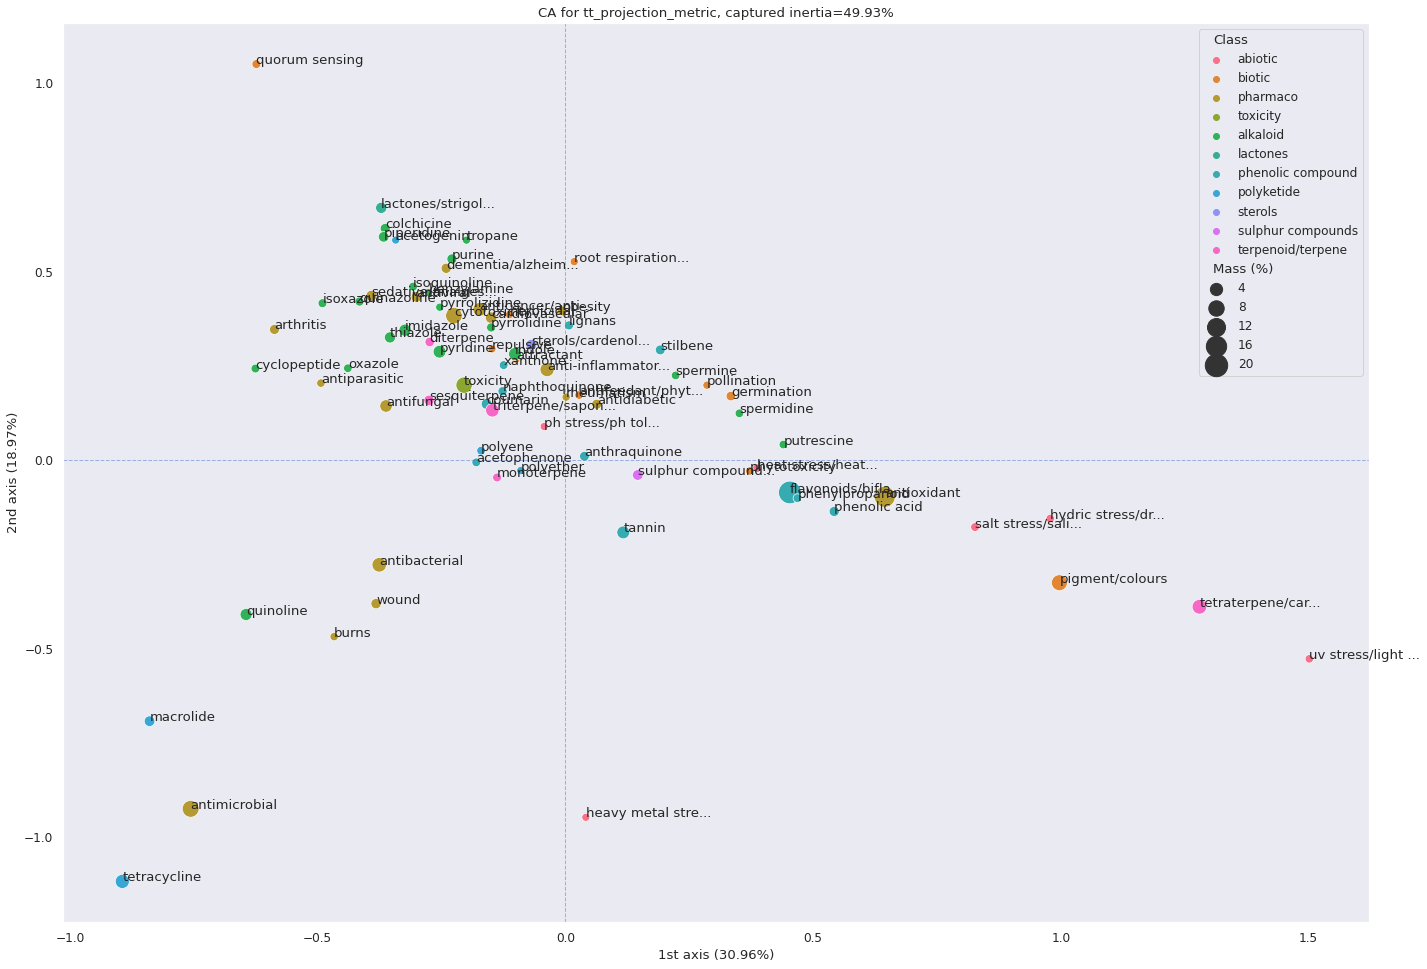

Drawing for row_implication_metric


<Figure size 1684.8x1190.88 with 1 Axes>

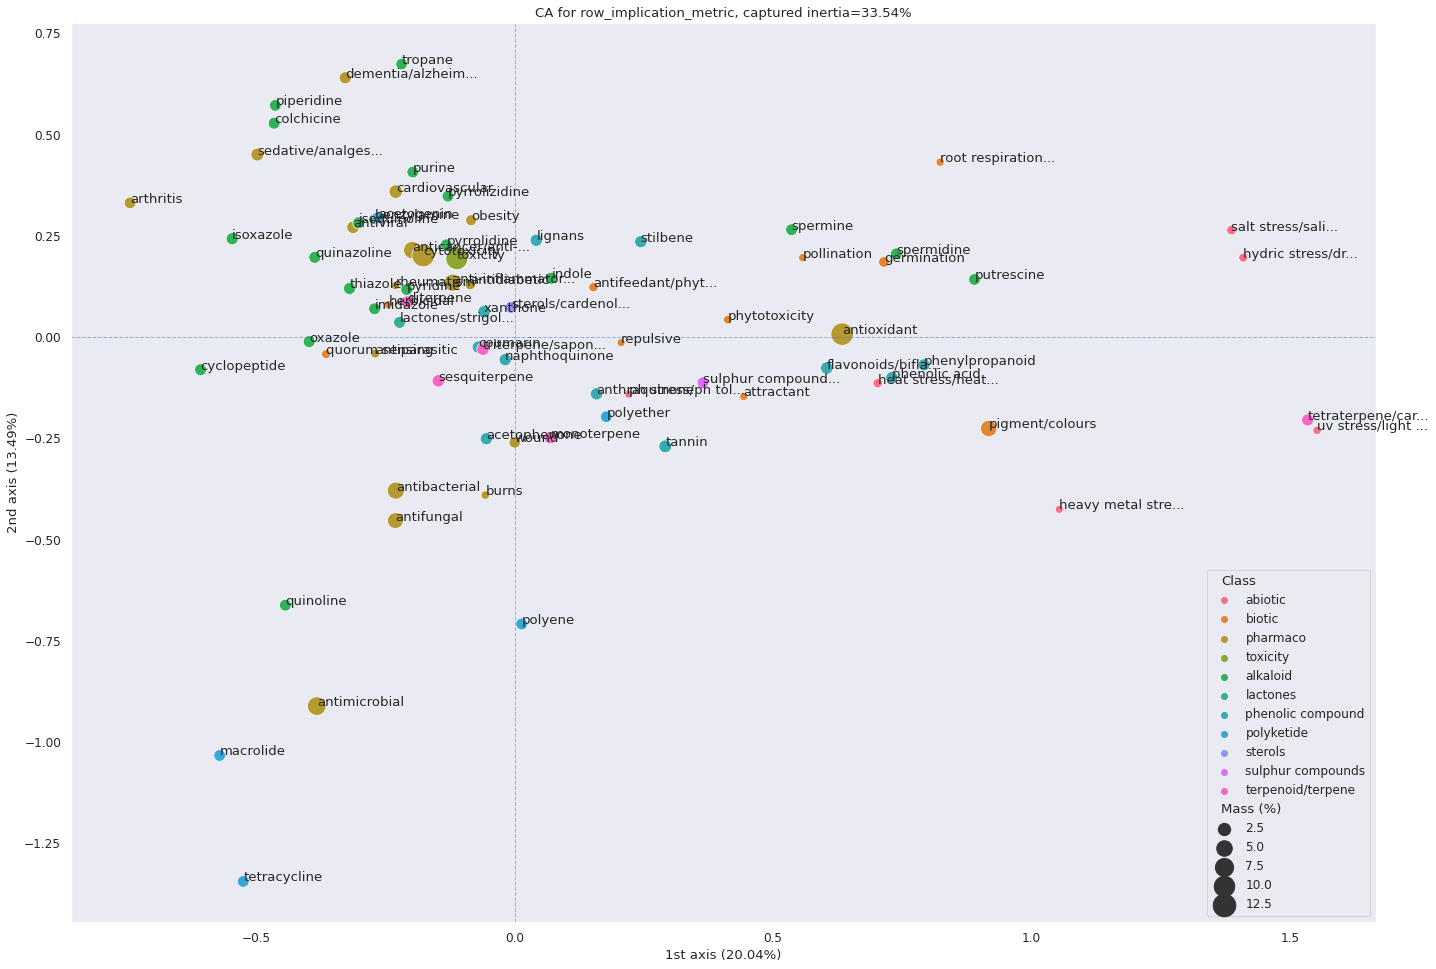

Drawing for col_implication_metric


<Figure size 1684.8x1190.88 with 1 Axes>

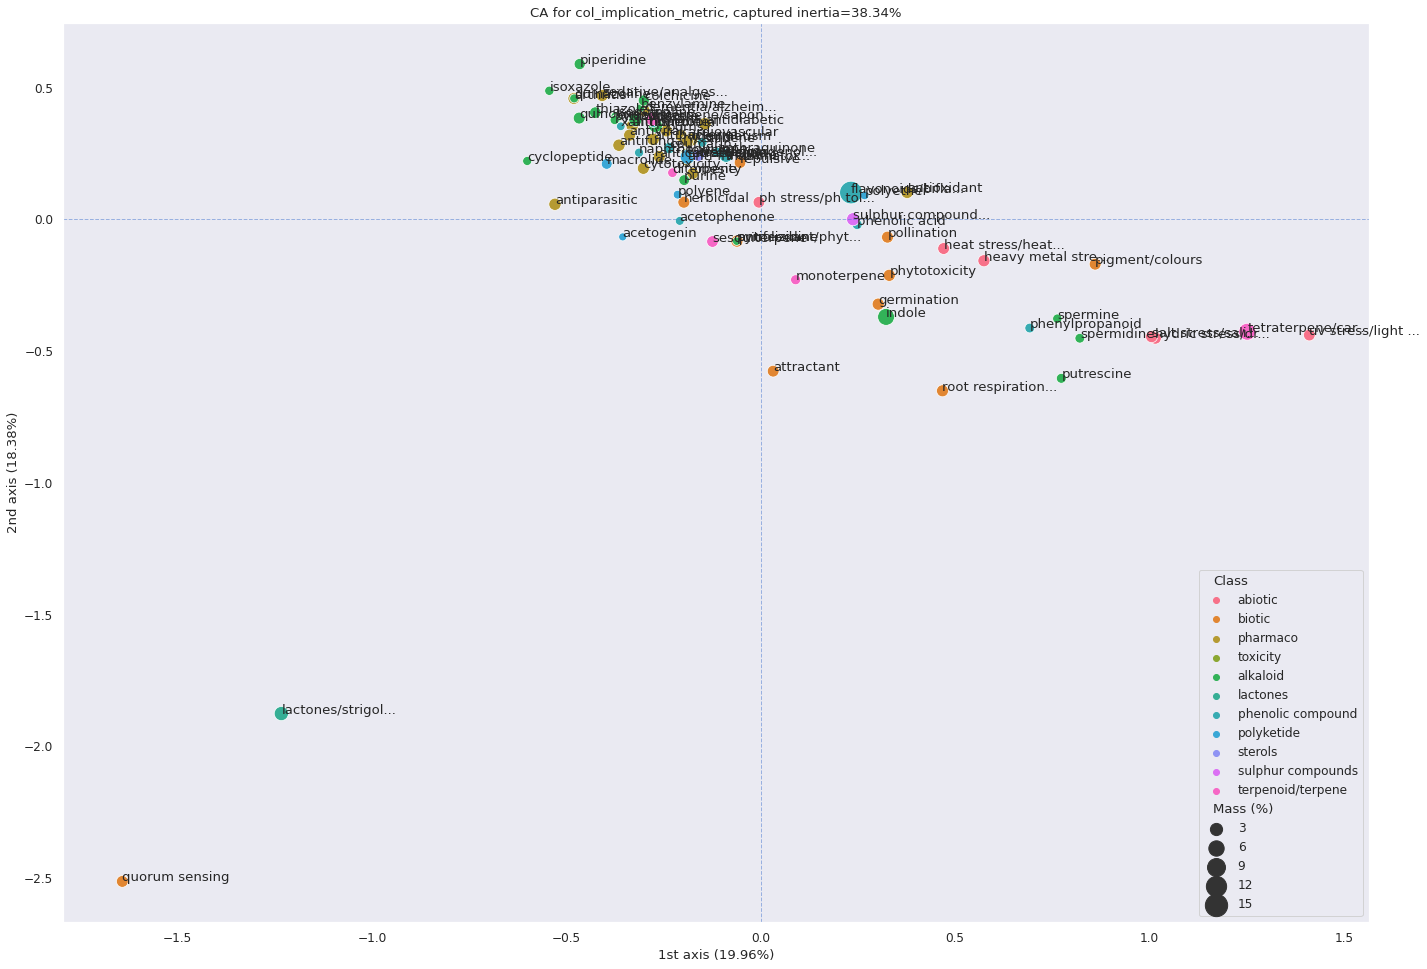

Drawing for fowlkes_mallows_metric


<Figure size 1684.8x1190.88 with 1 Axes>

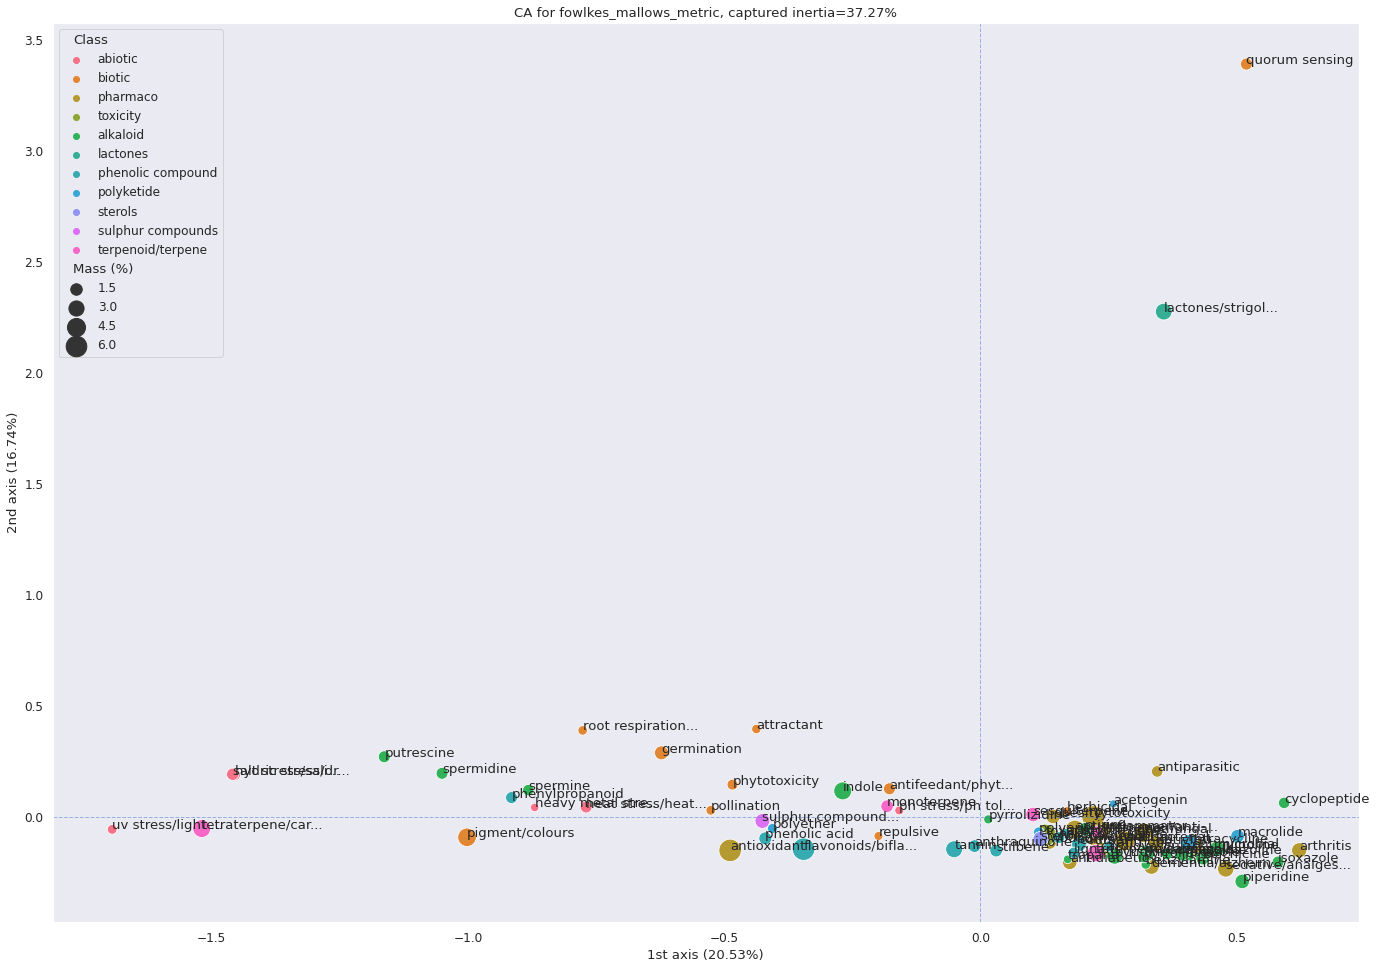

Drawing for fraction_metric


<Figure size 1684.8x1190.88 with 1 Axes>

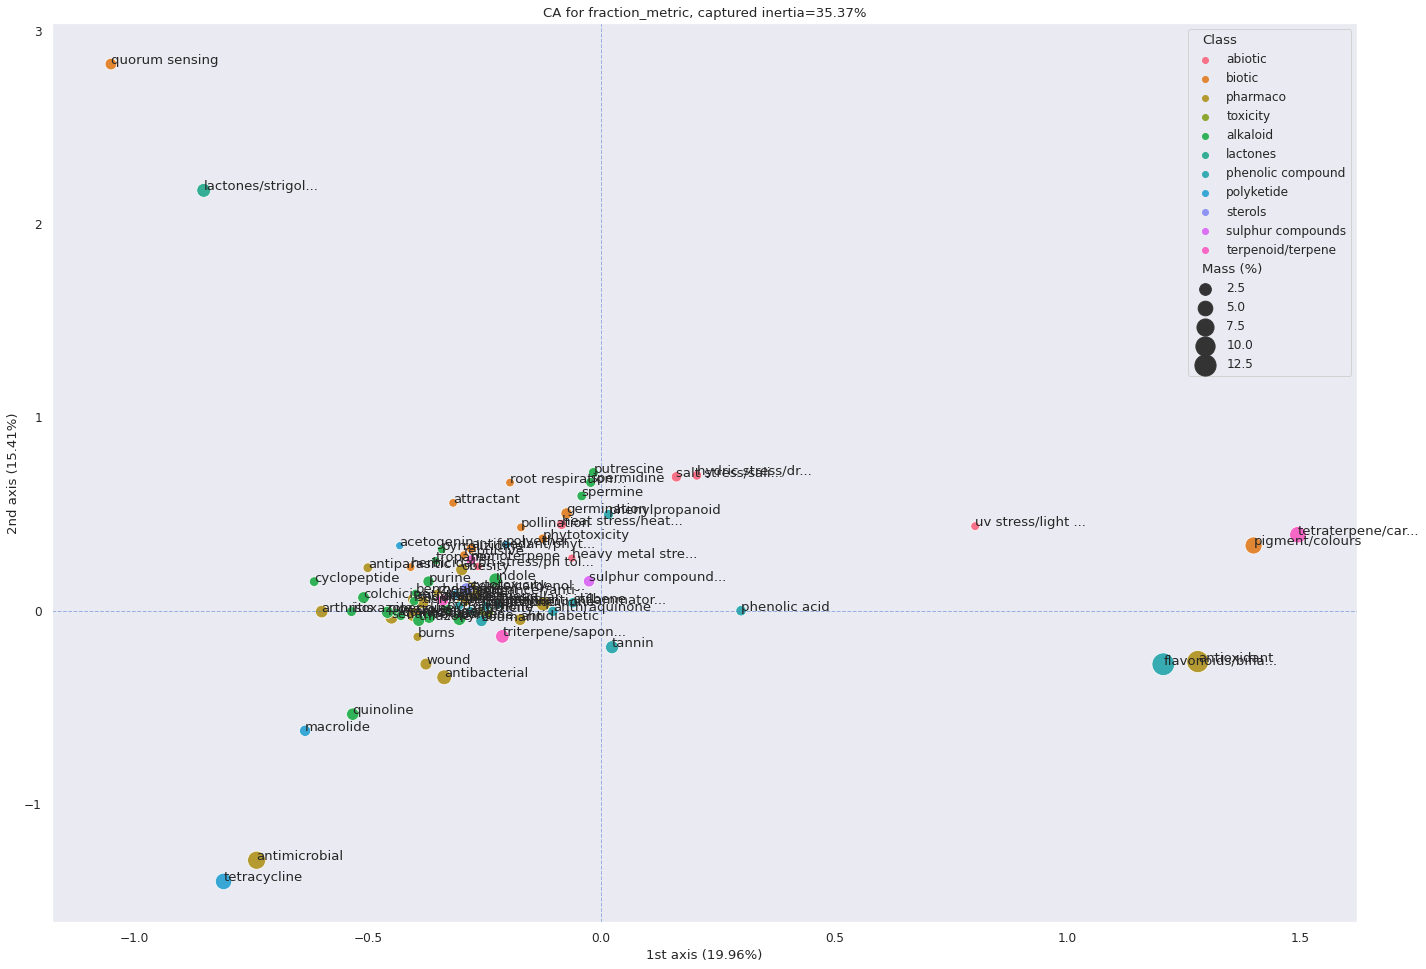

Drawing for odds_metric


<Figure size 1684.8x1190.88 with 1 Axes>

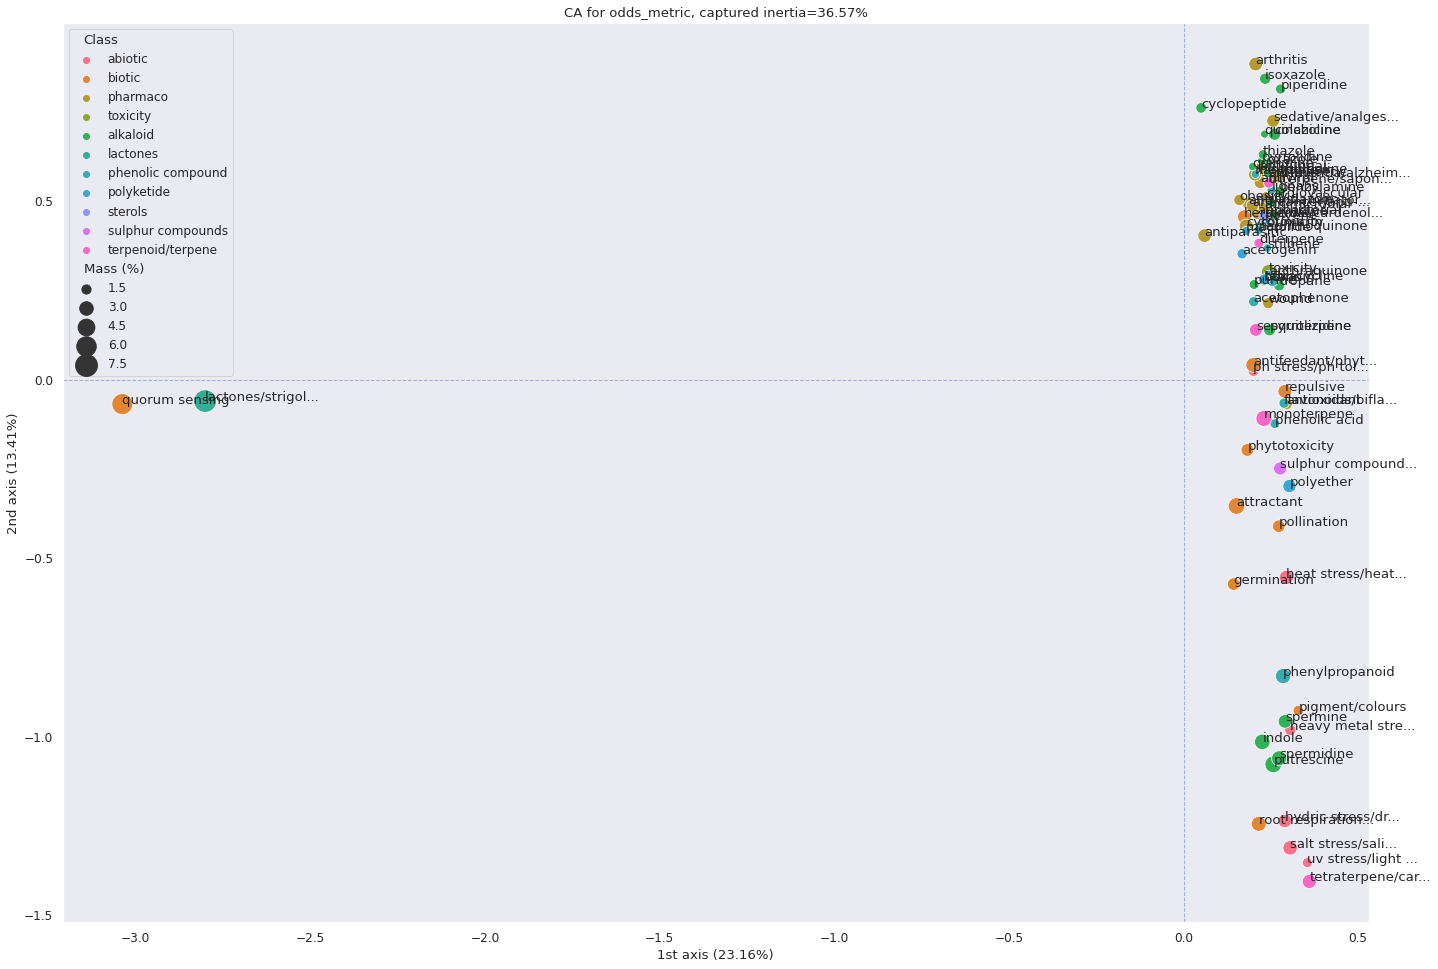

Drawing for accuracy_metric


<Figure size 1684.8x1190.88 with 1 Axes>

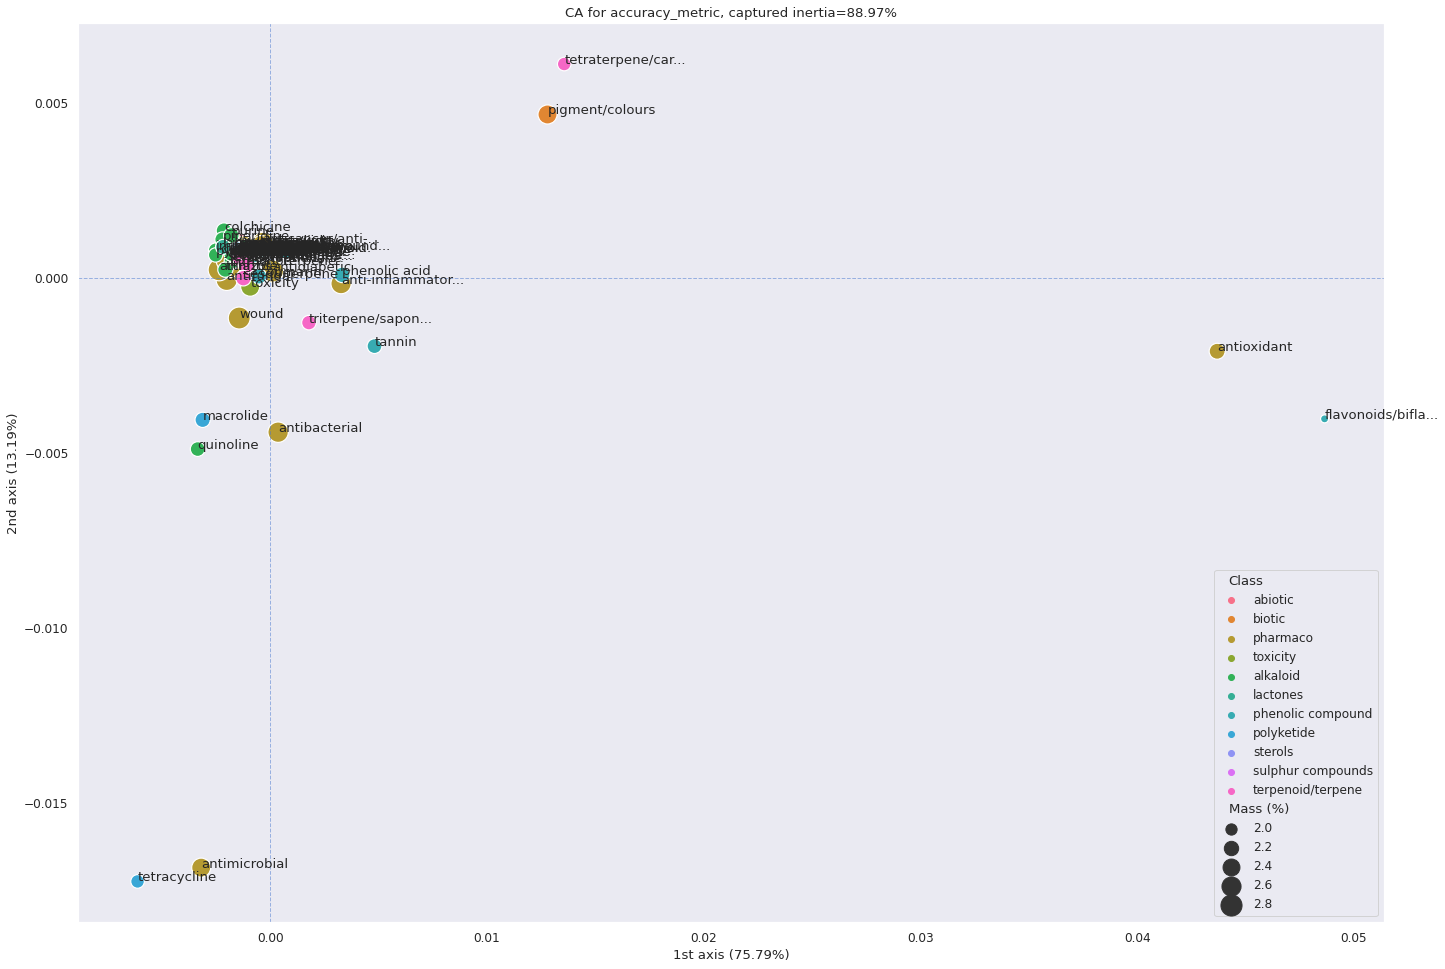

In [33]:
SHIFT = 0.0

for f_name, df in score_df.items() :#  [(x, y) for (x,y) in if "implication" not in f_name]:
    print(f"Drawing for {f_name}")
    ca = catk.ca.CA(SEED)
    ca.fit(shortnamer(df))
    res = ca.contributions(K=2)
    res["Class"] = [idx[0] for idx in res.index]
    axes = ca.axes()

    # its not meaning ful to draw both rows and cols for those metrics
    # if f_name == "row_implication_metric":
    #     res = res[res["Kind"] == "Compounds"]
    # if f_name == "col_implication_metric":
    #     res = res[res["Kind"] == "Activities"]

    x_axis = ("Coords (princ.)", 1)
    y_axis = ("Coords (princ.)", 2)
    ax = sns.scatterplot(data=res, x=x_axis, y=y_axis, hue="Class", size="Mass (%)", sizes=(64, 512))
    plt.axhline(y=0, linestyle="--", linewidth=1.0, alpha=0.5)
    plt.axvline(x=0, linestyle="--", linewidth=1.0, alpha=0.5)

    ax.set_title(f"CA for {f_name}, captured inertia={axes.loc[2, 'Cumulated (%)']:.2f}%")
    ax.set_xlabel(f"1st axis ({axes.loc[1, 'Inertia (%)']:.2f}%)")
    ax.set_ylabel(f"2nd axis ({axes.loc[2, 'Inertia (%)']:.2f}%)")
    for index, row in res.iterrows():
        ax.annotate(index[1], (row[x_axis] + SHIFT, row[y_axis] + SHIFT))
    plt.show()


## Implication rules

We summarize the top _k_ _row to col_ and _col to row_ implications.

In [12]:
def clean_implications(axis=0):
    if axis == 0:
        f_name = "row_implication_metric"
    elif axis == 1:
        f_name = "col_implication_metric"
    else:
        raise IndexError(f"no such axis {axis}")

    df = score_df[f_name].copy()
    df_support = (
        score_df["tt_projection_metric"]
        .melt(ignore_index=False, value_name="value")
        .reset_index()
        .drop(columns=["level_0", "variable_0"], axis=1)
        .rename(columns={"level_1": "compound", "variable_1": "activity"})
        .set_index(["compound", "activity"])
    )

    df.index = df.index.droplevel(0)
    df.columns = df.columns.droplevel(0)
    df = df.melt(ignore_index=False, value_name="%").reset_index()
    df.set_index(["index", "variable"], inplace=True)
    df.index.set_names(["compound", "activity"], inplace=True)
    df["mass"] = df_support["value"]
    # df["support"] = df_support["value"] / df["%"]
    df.sort_values(by="%", ascending=False, inplace=True)
    return df


# clean_implications(axis = 0)


For instance, the first line states that 75.8% of papers with keyword _phenolic acid_ also have the _antioxidant_ keywords: are 1879 papers with both keywords out of 1879 + 600 about _phenolic acid_.

In [13]:
NB_RULES_SHOWN = 20

print("Best implication rules : compound => activity")
display(clean_implications(0).head(NB_RULES_SHOWN))
print("phenolic acid/antioxidant submatrix")
display(dataset.loc[("phenolic compound", "phenolic acid"), ("pharmaco", "antioxidant")])


Best implication rules : compound => activity


,,%,mass
compound,activity,,
phenolic acid,antioxidant,0.719,6464
pyrrolizidine,toxicity,0.659,720
tetracycline,antimicrobial,0.621,22595
acetogenin,cytotoxicity,0.608,287
tetraterpene/carotenoid/xanthophyll,pigment/colours,0.605,22347
flavonoids/biflavonoids/anthocyanin,antioxidant,0.568,55239
polyene,antifungal,0.566,1767
macrolide,antimicrobial,0.486,6487
tannin,antioxidant,0.459,9260


phenolic acid/antioxidant submatrix


,w/o,w/
w/o,336696,92486
w/,2528,6464


Now, the other way around

In [14]:
print("Best implication rule : activity => compound")
clean_implications(1).swaplevel().head(NB_RULES_SHOWN)

Best implication rule : activity => compound


,,%,mass
activity,compound,,
quorum sensing,lactones/strigolactones,0.784,3591
root respiration/branching factors/root formation,indole,0.691,656
uv stress/light stress/uv tolerance/light tolerance/uv resistance/light resistance/uv impact/light impact/uv change/light change/irradiance,tetraterpene/carotenoid/xanthophyll,0.613,1433
antioxidant,flavonoids/biflavonoids/anthocyanin,0.558,55239
rheumatism,flavonoids/biflavonoids/anthocyanin,0.411,338
antidiabetic,flavonoids/biflavonoids/anthocyanin,0.397,3629
pigment/colours,tetraterpene/carotenoid/xanthophyll,0.394,22347
antimicrobial,tetracycline,0.388,22595
hydric stress/drought stress/hydric tolerance/drought tolerance/hydric resistance/drought resistance/hydric impact/drought impact/hydric change/drought change,tetraterpene/carotenoid/xanthophyll,0.349,880
